In [1]:
from aiida.orm import Dict, Str,List,Code,FolderData,RemoteData,Float,Int,ArrayData,load_code,Bool,load_group,KpointsData,BandsData,TrajectoryData
from aiida.engine import run,submit,run_get_node,ExitCode,WorkChain,workfunction,calcfunction,ToContext
from aiida.plugins import DataFactory
import os
import pickle
import numpy as np

from cryspy.job import ctrl_job


StructureCollectionData = DataFactory("cryspy.structurecollection")
PandasFrameData = DataFactory('dataframe.frame')
RinData = DataFactory('cryspy.rin_data')
EAData = DataFactory('cryspy.ea_data')
StructureData = DataFactory('core.structure')

In [2]:
from aiida import load_profile
load_profile()

Profile<uuid='96abe6da047b431294d9057e5dbc634c' name='quicksetup'>

In [3]:

class initialize_workchain(WorkChain):

    @classmethod
    def define(cls,spec):
        super().define(spec)
        spec.input("cryspy_in_filename",valid_type=Str)
        #lock_cryspyをinputで入れる？

        spec.output("initial_structures",valid_type=StructureCollectionData)
        spec.output("opt_structures",valid_type=StructureCollectionData)
        spec.output("rslt_data",valid_type=PandasFrameData)
        spec.output("cryspy_in",valid_type=RinData)
        spec.output("id_queueing",valid_type=List)
        spec.output('detail_data', valid_type=(Dict,EAData))

        spec.outline(
            cls.call_crsypy_initialize
        )

    def call_crsypy_initialize(self):
        from cryspy.interactive import action
        init_struc_data, opt_struc_data, rin, rslt_data, id_queueing, detail_data = action.initialize()


        init_struc_node = StructureCollectionData(structures=init_struc_data)
        init_struc_node.store()
        self.out('initial_structures', init_struc_node)

        opt_struc_node = StructureCollectionData(structures=opt_struc_data)
        opt_struc_node.store()
        self.out('opt_structures', opt_struc_node)

        rslt_node = PandasFrameData(rslt_data)
        rslt_node.store()
        self.out('rslt_data', rslt_node)

        cryspy_in = RinData(rin)
        cryspy_in.store()
        self.out("cryspy_in", cryspy_in)

        id_queueing_node = List(list=id_queueing)
        id_queueing_node.store()
        self.out("id_queueing", id_queueing_node)

        algo = rin.algo
        
        if algo == "RS":
            RS_node = Dict(dict=detail_data)
            RS_node.store()
            self.out('detail_data', RS_node)

        elif algo == "EA":
            ea_node = EAData(detail_data)
            ea_node.store()
            self.out('detail_data', ea_node)

In [4]:
result,node = run.get_node(initialize_workchain, cryspy_in_filename="cryspy_in")

[2025-08-04 18:10:08,282][cryspy_init][INFO] 


Start CrySPY 1.4.0b10


[2025-08-04 18:10:08,282][cryspy_init][INFO] # ---------- Library version info
[2025-08-04 18:10:08,283][cryspy_init][INFO] pandas version: 2.2.2
[2025-08-04 18:10:08,284][cryspy_init][INFO] pymatgen version: 2024.6.10
[2025-08-04 18:10:08,284][cryspy_init][INFO] pyxtal version: 0.6.7
[2025-08-04 18:10:08,284][cryspy_init][INFO] # ---------- Read input file, cryspy.in
[2025-08-04 18:10:08,286][write_input][INFO] [basic]
[2025-08-04 18:10:08,286][write_input][INFO] algo = RS
[2025-08-04 18:10:08,286][write_input][INFO] calc_code = QE
[2025-08-04 18:10:08,286][write_input][INFO] tot_struc = 3
[2025-08-04 18:10:08,287][write_input][INFO] nstage = 2
[2025-08-04 18:10:08,287][write_input][INFO] njob = 2
[2025-08-04 18:10:08,287][write_input][INFO] jobcmd = qsub
[2025-08-04 18:10:08,287][write_input][INFO] jobfile = job_cryspy
[2025-08-04 18:10:08,288][write_input][INFO] 
[2025-08-04 18:10:08,288][write_input][INFO] [str

/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:63: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf(Path(td) / self.DEFAULT_FILENAME, "w", format="table")
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:68: AiidaDeprecationWarning: `PandasFrameData.set_attribute` is deprecated, use `PandasFrameData.base.attributes.set` instead. (this will be removed in v3)
  self.set_attribute("_pandas_data_hash", self._hash_dataframe(df))
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:69: AiidaDeprecationWarning: `PandasFrameData.set_attribute` is deprecated, use `PandasFrameData.base.attributes.set` instead. (this will be removed in v3)
  self.set_attribute("index", list(df.index))
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python

In [5]:
result

{'initial_structures': <StructureCollectionData: uuid: 432e2791-2d1f-4659-820c-456ebd432b1f (pk: 13539)>,
 'opt_structures': <StructureCollectionData: uuid: 06bbb8d5-899e-4db3-8bf3-38a53f4ec490 (pk: 13540)>,
 'rslt_data': <PandasFrameData: uuid: 19846262-7dd5-45f3-900a-49a4433313ce (pk: 13541)>,
 'cryspy_in': <RinData: uuid: edf5a590-d2c3-4860-bfc2-c8e69afaa47f (pk: 13542)>,
 'id_queueing': <List: uuid: ac028ec4-77b1-4047-aeaf-1217cd313258 (pk: 13543) value: [0, 1, 2]>,
 'detail_data': <Dict: uuid: b180d371-3429-491f-aa8f-306f8d7916df (pk: 13544)>}

In [6]:
initial_structures_node = result['initial_structures']
opt_structures_node = result['opt_structures']
rslt_data_node = result['rslt_data']
cryspy_in_node = result['cryspy_in']
id_queueing_node = result['id_queueing']
detail_data_node = result['detail_data']

In [14]:
SIMULATOR_PREFIX = 'simulator_'
ID_PREFIX = 'ID_'


class optimization_WorkChain(WorkChain):
    @classmethod
    def define(cls, spec):
        super().define(spec)
        spec.input("code", valid_type=Code, help='label of your code')
        spec.input("structure", valid_type=StructureData, help='selected structure for optimization')
        spec.input('parameters', valid_type=Dict)
        spec.input("pseudo", valid_type=Str, help='label of the pseudopotential to use')
        spec.input("kpoints", valid_type=KpointsData, help='k-points data for the calculation')
        spec.input('options', valid_type=Dict, default=Dict, help='metadata.options')

        spec.outline(
            cls.submit_workchains,
            cls.inspect_workchains
        )
        
        spec.output("output_band", valid_type=BandsData)
        spec.output("output_parameters", valid_type=Dict)
        spec.output("output_structure", valid_type=StructureData)
        spec.output("output_trajectory", valid_type=TrajectoryData)
        spec.output("retrieved", valid_type=FolderData)
        spec.output("remote_folder", valid_type=RemoteData)


    def submit_workchains(self):
        # initial_structures_dict = self.inputs.initial_structures.structurecollection #初期構造をpymatgenの構造として取得
        code = self.inputs.code
        structure = self.inputs.structure
        parameters = self.inputs.parameters
        kpoints = self.inputs.kpoints
        metadata_options = self.inputs.options.get_dict()

        builder = code.get_builder()

        pseudo_family = load_group(self.inputs.pseudo.value)
        builder.pseudos = pseudo_family.get_pseudos(structure=structure)
        
        # 推奨されるカットオフエネルギーを取得
        cutoff_wfc, cutoff_rho = pseudo_family.get_recommended_cutoffs(
            structure=structure,
            unit='Ry'
        )
        
        parameters['SYSTEM']['ecutwfc'] = cutoff_wfc
        parameters['SYSTEM']['ecutrho'] = cutoff_rho


        builder.structure = structure
        builder.parameters = parameters
        builder.kpoints = kpoints
        builder.metadata.options = metadata_options
        # submit workchain
        future = self.submit(builder)
        return ToContext(my_future=future)


    def inspect_workchains(self):
        #sleepを入れて並列を確認
        calculations = self.ctx.my_future

        if 'output_band' in calculations.outputs:
            self.out("output_band", calculations.outputs.output_band)
        if 'output_parameters' in calculations.outputs:
            self.out("output_parameters", calculations.outputs.output_parameters)
        if 'output_structure' in calculations.outputs:
            self.out("output_structure", calculations.outputs.output_structure)
        if 'output_trajectory' in calculations.outputs:
            self.out("output_trajectory", calculations.outputs.output_trajectory)
        if 'retrieved' in calculations.outputs:
            self.out("retrieved", calculations.outputs.retrieved)
        if 'remote_folder' in calculations.outputs:
            self.out("remote_folder", calculations.outputs.remote_folder)




In [15]:
@calcfunction
def pack_results(**kwargs):
    """
    複数の計算結果ノードを受け取り、エネルギーと構造の辞書（pymatgen.as_dict()）
    をまとめた一つのDictノードを返す。
    """
    final_results = {}

    # 'id_0'のようなキーでデータをグループ化するための辞書
    grouped_data = {}
    for key, node in kwargs.items():
        # キーの名前からID部分 ("id_0"など) を取り出す
        id_ = '_'.join(key.split('_')[1:])

        # 辞書がなければ作成
        if id_ not in grouped_data:
            grouped_data[id_] = {}

        # キーのプレフィックスでresultかstructureかを判断
        if key.startswith('result_'):
            grouped_data[id_]['result'] = node
        elif key.startswith('structure_'):
            grouped_data[id_]['structure'] = node

    # グループ化されたデータを処理
    for id_, data in grouped_data.items():
        # resultノードからエネルギーを取得
        energy = data['result'].get_dict()['energy']

        # structureノードからpymatgenオブジェクトを取得し、JSON互換の辞書に変換
        struc_dict = data['structure'].get_pymatgen().as_dict()

        final_results[id_] = {'energy': energy, 'structure': struc_dict}

    # Python辞書をAiiDAのDictノードとして返す
    return Dict(dict=final_results)

# @calcfunction
# def pack_energy(**results):
#     """
#     複数の計算結果（Dictノード）を受け取り、
#     IDをキー、エネルギーを値とする一つの辞書を作成して返す。
#     """
#     energy_dict = {}

#     # results.items() をループ処理する（idは "id_0" のような文字列, val は AiiDAのDictノード）
#     for id, val in results.items():
#         # val（AiiDAのDictノード）からPython辞書を取得
#         result_dict = val.get_dict()

#         # 'info'辞書の中から'chgnet_energy'を取得
#         energy = result_dict.get('info', {}).get('chgnet_energy')

#         if energy is not None:
#             # 新しい辞書にIDとエネルギーを格納
#             energy_dict[id] = energy

#     # 最終的なPython辞書をAiiDAのDictノードに変換して返す
#     return Dict(dict=energy_dict)


class multi_structure_optimize_WorkChain(WorkChain):
    @classmethod
    def define(cls, spec):
        super().define(spec)
        spec.input("initial_structures", valid_type=StructureCollectionData, help='initial structure data for optimization')
        spec.input("opt_structures", valid_type=StructureCollectionData, help='optimized structure data')
        spec.input("rslt_data", valid_type=PandasFrameData, help='result data in Pandas DataFrame format')
        spec.input("id_queueing", valid_type=List, help='list of IDs for queuing structures for optimization')
        spec.input("cryspy_in", valid_type=RinData, help='RinData for cryspy input')
        spec.input("detail_data",valid_type=(Dict,EAData), help='EA data for optimization')
        spec.input("code", valid_type=Code, help='label of your code')
        spec.input("parameters", valid_type=Dict, help='parameters for the calculation')
        spec.input("pseudo", valid_type=Str, help='pseudopotential data for the calculation')
        spec.input("kpoints", valid_type=KpointsData, help='k-points data for the calculation')
        spec.input('options', valid_type=Dict, default=Dict, help='metadata.options')

        # spec.output("energy_results", valid_type=Dict)
        # spec.output("all_results", valid_type=Dict, help='results of all workchains')
        # spec.output("retrieved", valid_type=FolderData)
        # spec.output("opt_structure", valid_type=StructureData)

        # spec.output_namespace("structure", valid_type=StructureData, dynamic=True)
        # spec.output_namespace("results", valid_type=Dict, dynamic=True)
        spec.output("structure_energy_data", valid_type=Dict, help='sorted energy results with structure data')
        # spec.output("results_energy", valid_type=Dict, help='sorted energy results')
        # spec.output("opt_structure", valid_type=StructureCollectionData)
        spec.output("opt_struc_data", valid_type=StructureCollectionData, help='optimized structure data')
        spec.output("rslt_data", valid_type=PandasFrameData, help='result data in Pandas DataFrame format')
        # spec.output("retrieved", valid_type=FolderData, help='retrieved data from the workchain')

        # spec.output_namespace("results", valid_type=Dict, dynamic=True)
        spec.output_namespace("structure", valid_type=StructureData, dynamic=True)
        # spec.output_namespace("retrieved", valid_type=FolderData, dynamic=True)
        # spec.output_namespace("remote_folder", valid_type=RemoteData, dynamic=True)
        # spec.output_namespace("time_dependent_computes", valid_type=ArrayData, dynamic=True)

        spec.exit_code(300, 'ERROR_SUB_PROCESS_FAILED', message='One or more subprocesses failed.')

        spec.outline(
            cls.optimize,
            cls.collect_results
        )


    def optimize(self):
        initial_structures_dict = self.inputs.initial_structures.structurecollection
        calculations = {}

        # metadata = {
        #     'label': 'geometry_optimization',  # 計算にラベルを付ける（推奨）
        #     'description': 'Sub-process for geometry optimization',
        #     'options': {
        #         "resources": {"num_machines": 1, "num_mpiprocs_per_machine": 8}
        #     }
        # }

        for id in self.inputs.id_queueing:
            structure_ = initial_structures_dict[id]
            structure = StructureData(pymatgen=structure_)
            structure.store()
            self.out(f"structure.{id}", structure)

            future = self.submit(optimization_WorkChain,{
                'code': self.inputs.code,
                'structure': structure,
                'parameters': self.inputs.parameters,
                'kpoints': self.inputs.kpoints,
                'pseudo': self.inputs.pseudo,
                'options': self.inputs.options,
            })

            label = f"id_{id}"  # IDを文字列としてラベル付け
            calculations[label] = future

        return ToContext(**calculations)

            # self.ctx.node[id] = results_.get_node()

            # for key, node in self.ctx.results[id].items():
            #     self.out(f"{key}.{id}", node)
        # self.out("results", self.ctx.result)

    def collect_results(self):
        init_struc_data = self.inputs.initial_structures.structurecollection
        opt_struc_data = self.inputs.opt_structures.structurecollection
        structure_dict = {}
        results_dict = {}
        calcfunc_inputs = {}
        # opt_struc_data = {}


        # ---------- mkdir work/fin
        os.makedirs('work/fin', exist_ok=True)


        rslt_data_node = self.inputs.rslt_data
        # pandas.DataFrame として取り出す
        rslt_data = rslt_data_node.df


            # 成功判定のチェック
        for id, calculation in self.ctx.items():
            if not calculation.is_finished_ok:
                self.report(f'Sub-process for ID {id} failed with exit status {calculation.exit_status}')
                return self.exit_codes.ERROR_SUB_PROCESS_FAILED


        for cid, results_node in self.ctx.items():
            # cid = int(cid.split('_')[-1])  # IDを整数に変換
            # results_output = result_node.outputs
            # key = f"id_{cid}"  # ← 文字列のキーを作成
            # results_dict[cid] = results_node.outputs.results_dict
            # structure_dict[cid] = results_node.outputs.final_structure

            calcfunc_inputs[f"result_{cid}"] = results_node.outputs.output_parameters
            calcfunc_inputs[f"structure_{cid}"] = results_node.outputs.output_structure

            rin_data = self.inputs.cryspy_in
            # rin オブジェクトを取り出す
            rin = rin_data.rin  # ← Python オブジェクトとして使用可能

            energy = results_node.outputs.output_parameters['energy']  # 'chgnet_energy' キーからエネルギーを取得
            opt_struc = results_node.outputs.output_structure.get_pymatgen()

            print("energy:", energy)

            cid = int(cid.split('_')[-1])  # IDを整数に変換
            os.makedirs(f'work/{cid}',exist_ok=True)
            work_path = f'work/{cid}/'

            if rin.algo == "RS":
                gen_ = None

            elif rin.algo == "EA":
                gen_ = self.inputs.detail_data.ea_data[0]  # EADataから世代情報を取得

            #cryspyによる結果の保存
            opt_struc_data, rslt_data = ctrl_job.regist_opt(
                rin,
                cid,
                work_path,#どこでもいい
                init_struc_data,
                opt_struc_data,
                rslt_data,
                opt_struc,
                energy,
                magmom=np.nan,
                check_opt=None,
                ef=None,
                nat=None,
                n_selection=None,
                gen=gen_
            )

            # retrieved = results_output.retrieved
            # self.out("retrieved", retrieved)

        # results_dict_node = Dict(dict=results_dict)
        # structure_dict_node = Dict(dict=structure_dict)

        structure_energy_data_results = pack_results(**calcfunc_inputs)
        self.out("structure_energy_data", structure_energy_data_results)

        # sorted_energy = pack_energy(**results_dict)
        # self.out("results_energy", sorted_energy)

        # opt_structure = pack_structure(**structure_dict)
        # self.out("opt_structure", opt_structure)

        opt_struc_node = StructureCollectionData(structures=opt_struc_data)
        opt_struc_node.store()
        self.out('opt_struc_data', opt_struc_node)

        rslt_node = PandasFrameData(rslt_data)
        rslt_node.store()
        self.out('rslt_data', rslt_node)

In [9]:
# Generate a 2x2x2 Monkhorst-Pack mesh
kpoints = KpointsData()
kpoints.set_kpoints_mesh([2, 2, 2])

In [10]:
parameters = Dict({
    'CONTROL': {
        'calculation': 'relax',
        # 'outdir': './outdir/'
    },
    'SYSTEM': {
        # 'ecutwfc': 40,
        # 'ecutrho': 200,
        'occupations': 'smearing',
        'smearing': 'gaussian',
        'degauss': 0.01
    },
    'ELECTRONS': {},
    'IONS': {},
    # 'CELL': {}
})

In [11]:
from aiida.orm import Str, Float, Bool
from aiida.orm import load_code
code = load_code("QE@script_ssh2")

inputs = {
        'initial_structures':initial_structures_node,
        'opt_structures':opt_structures_node,
        'id_queueing':id_queueing_node,
        'rslt_data':rslt_data_node,
        'cryspy_in':cryspy_in_node,
        'detail_data':detail_data_node,
        "code": code,
        "parameters": parameters,
        "kpoints": kpoints,
        "pseudo": Str('SSSP/1.3/PBEsol/efficiency'),
        "options": Dict(dict={'resources': {'tot_num_mpiprocs': 40,
                                         'parallel_env': 'smp'},
                                         'max_wallclock_seconds': 1800, "withmpi": False}),
    }

In [16]:
result,node = run.get_node(multi_structure_optimize_WorkChain, **inputs)

energy: -1225.8329766438
energy: -1231.0192208828
energy: -1211.6686304543


/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:63: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf(Path(td) / self.DEFAULT_FILENAME, "w", format="table")
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:68: AiidaDeprecationWarning: `PandasFrameData.set_attribute` is deprecated, use `PandasFrameData.base.attributes.set` instead. (this will be removed in v3)
  self.set_attribute("_pandas_data_hash", self._hash_dataframe(df))
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:69: AiidaDeprecationWarning: `PandasFrameData.set_attribute` is deprecated, use `PandasFrameData.base.attributes.set` instead. (this will be removed in v3)
  self.set_attribute("index", list(df.index))
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python

Success: Output written to `13553.dot.pdf`


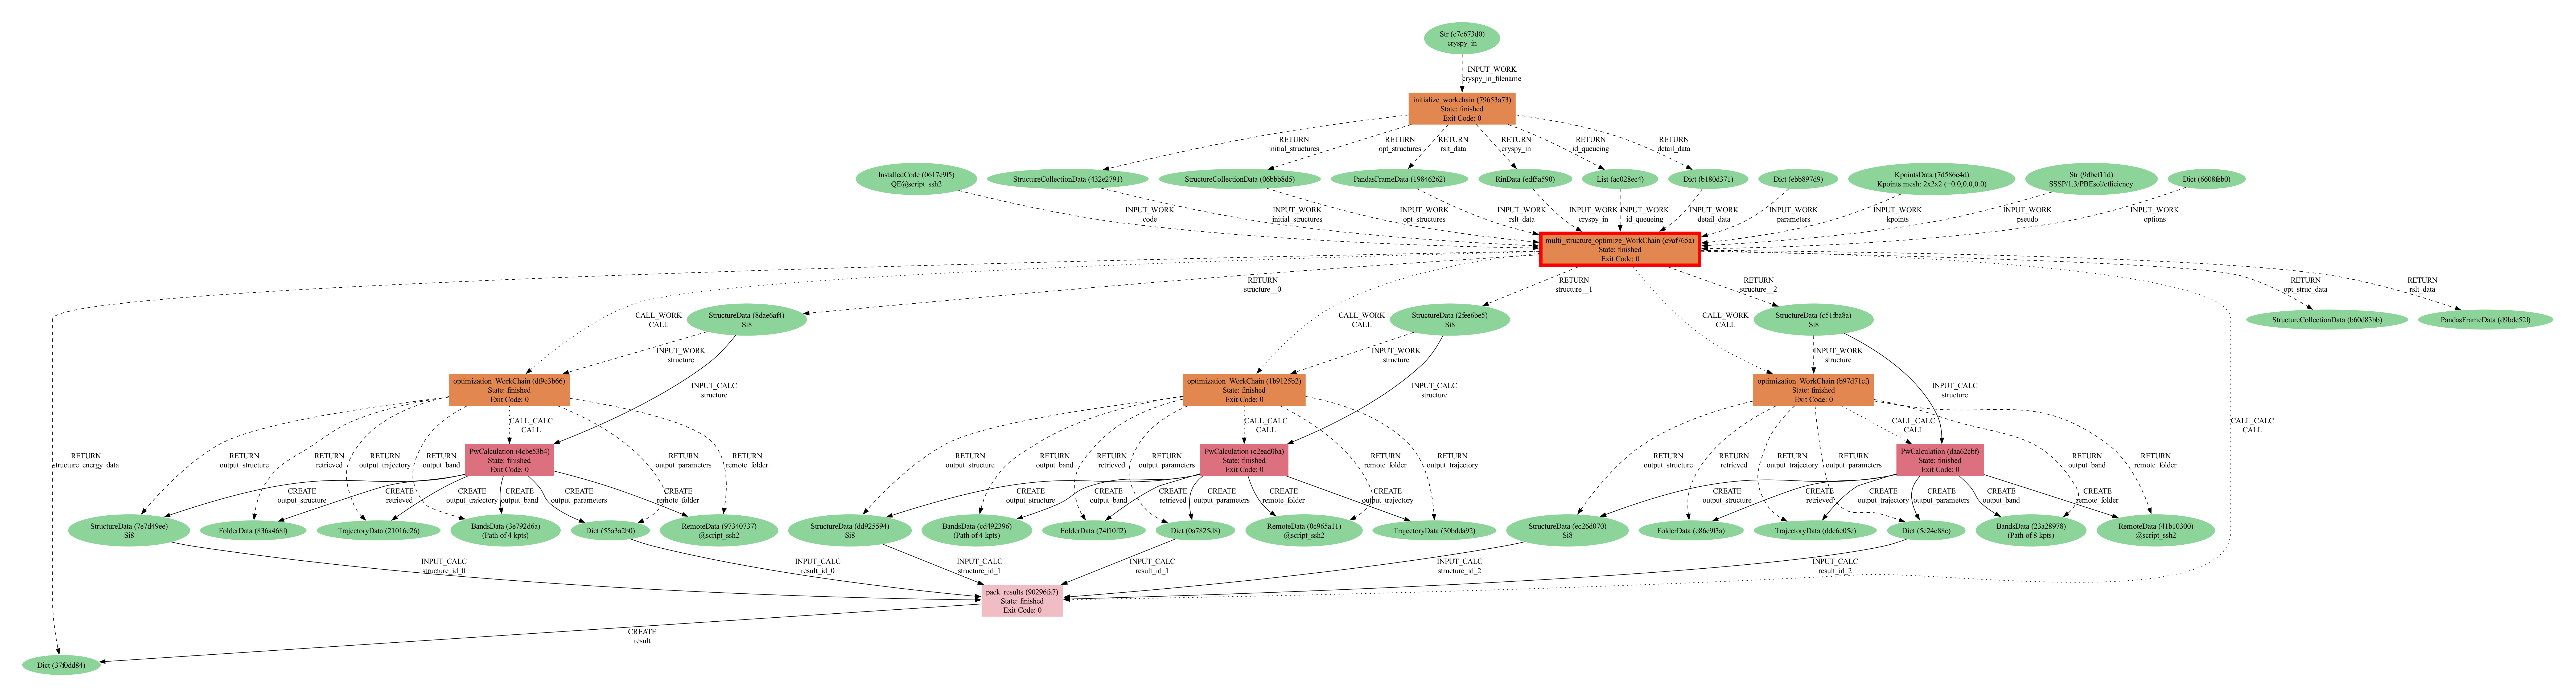

In [17]:
import subprocess
import fitz  # PyMuPDF
from PIL import Image
import io
from IPython.display import display

pk = node.pk

# Step 1: verdi コマンドで .dot.pdf を生成
subprocess.call(f"verdi node graph generate {pk}", shell=True)

# Step 2: PyMuPDF で PDF を開いて画像化
pdf_path = f"{pk}.dot.pdf"
doc = fitz.open(pdf_path)
page = doc[0]
pix = page.get_pixmap(dpi=150)

# Step 3: PIL で画像として表示
image = Image.open(io.BytesIO(pix.tobytes()))
display(image)

In [18]:
result

{'structure': {'0': <StructureData: uuid: 8dae6af4-3e45-45be-ab8c-aa9737278b64 (pk: 13554)>,
  '1': <StructureData: uuid: 2fee6be5-1b48-40ef-a577-2ad3f9f619af (pk: 13556)>,
  '2': <StructureData: uuid: c51fba8a-c1b2-498e-82ad-7ac8d701ee40 (pk: 13558)>},
 'structure_energy_data': <Dict: uuid: 37f0dd84-632d-42be-918b-cd0875fe5303 (pk: 13582)>,
 'opt_struc_data': <StructureCollectionData: uuid: b60d83bb-7141-40e1-91a7-e89246363728 (pk: 13583)>,
 'rslt_data': <PandasFrameData: uuid: d9bde52f-d9cf-4887-901f-cadd7fc976bd (pk: 13584)>}

In [19]:
result_energy = result['structure_energy_data'].get_dict()
result_energy

{'id_0': {'energy': -1225.8329766438,
  'structure': {'sites': [{'abc': [0.54765244267488,
      0.54765244267488,
      0.095304885383329],
     'xyz': [1.6295431570774, 1.6295431570774, 1.1804535342739],
     'label': 'Si',
     'species': [{'occu': 1.0, 'element': 'Si'}],
     'properties': {}},
    {'abc': [0.45234755729447, 0.45234755729447, 0.90469511461666],
     'xyz': [1.0706160575511e-14, 1.0706160575511e-14, 11.205622263687],
     'label': 'Si',
     'species': [{'occu': 1.0, 'element': 'Si'}],
     'properties': {}},
    {'abc': [0.24999999999436, 0.749999999979, 0.50000000000404],
     'xyz': [2.096221070788e-14, 1.6295431570773, 6.1930378990305],
     'label': 'Si',
     'species': [{'occu': 1.0, 'element': 'Si'}],
     'properties': {}},
    {'abc': [0.749999999979, 0.24999999999436, 0.50000000000404],
     'xyz': [1.6295431570773, 2.096221070788e-14, 6.1930378990305],
     'label': 'Si',
     'species': [{'occu': 1.0, 'element': 'Si'}],
     'properties': {}},
    {'abc

In [20]:
result['opt_struc_data'].structurecollection

{0: Structure Summary
 Lattice
     abc : 3.2590863142547 3.2590863142547 12.598638635757071
  angles : 97.43161671918342 97.43161671918342 90.0
  volume : 131.5604827751273
       A : 3.2590863142547 0.0 0.0
       B : 0.0 3.2590863142547 0.0
       C : -1.6295431570774 -1.6295431570774 12.386075797961
     pbc : True True True
 PeriodicSite: Si (1.63, 1.63, 1.18) [0.5477, 0.5477, 0.0953]
 PeriodicSite: Si (1.878e-14, 1.878e-14, 11.21) [0.4523, 0.4523, 0.9047]
 PeriodicSite: Si (1.05e-14, 1.63, 6.193) [0.25, 0.75, 0.5]
 PeriodicSite: Si (1.63, 1.05e-14, 6.193) [0.75, 0.25, 0.5]
 PeriodicSite: Si (1.63, -4.338e-14, 3.561) [0.6438, 0.1438, 0.2875]
 PeriodicSite: Si (-4.338e-14, 1.63, 3.561) [0.1438, 0.6438, 0.2875]
 PeriodicSite: Si (3.156e-14, 1.63, 8.825) [0.3562, 0.8562, 0.7125]
 PeriodicSite: Si (1.63, 3.156e-14, 8.825) [0.8562, 0.3562, 0.7125],
 1: Structure Summary
 Lattice
     abc : 4.512665023045274 4.5126650229754 13.808401778044
  angles : 90.0 90.0 120.00000000022085
  volum

In [21]:
result['rslt_data'].df

,Spg_num,Spg_sym,Spg_num_opt,Spg_sym_opt,E_eV_atom,Magmom,Opt
0,139,I4/mmm,139,I4/mmm,-1225.832977,NaN,None
1,143,P3,143,P3,-1231.019221,NaN,None
2,1,P1,2,P-1,-1211.668630,NaN,None
